<span style="font-size:large;">
<div style="text-align: right">IM-UH 1511 <b>Introduction to Digital Humanities</b><br/>
Student name: <span style="color:blue"><b>X XX</b></span><br/>
Grade: <span style="color:red"><b></b></span><br/><br/></div>

## <span style="color:red">HOMEWORK 10</span>
# <span style="color:green">Reddit mining and analysis

In [1]:
import praw  #!pip install praw
import pandas as pd
import datetime as dt
from datetime import datetime
import requests
import json
from bs4 import BeautifulSoup
import urllib, os, codecs, random, operator, re, string, copy, dateutil.parser, itertools, pickle, datetime, math, pandas as pd, numpy as np, seaborn as sns, networkx as nx, matplotlib.pyplot as plt
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from collections import Counter
from string import punctuation, digits
import pathlib
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')
import inflect
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from nltk.stem.porter import *
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.corpora import Dictionary
import pyLDAvis
from pyLDAvis import gensim as pgensim
pyLDAvis.enable_notebook()

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter('ignore')

In [2]:
r = praw.Reddit(client_id='XXXX',
                client_secret='XXXX',
                password='XXXX',
                user_agent='XXXX',
                username='XXXX')
print(r.user.me())

dhclass


In [3]:
subreddit="Devs" 
titlename = "Devs Reddit posts" 
npo=1000
posts = []
cvd_subreddit = r.subreddit(subreddit)
for post in cvd_subreddit.hot(limit=npo):
    if post.author==None:
        posts.append([post.title, post.score, "deleted", post.url, post.num_comments, post.selftext, post.created])
    else:
        posts.append([post.title, post.score, post.author.name, post.url, post.num_comments, post.selftext, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'redditor', 'url', 'num_comments', 'body', 'created']) #'subreddit', 
posts['created'] = pd.to_datetime(posts['created'], unit='s')
npo=len(posts)
# print(npo)
mind=posts.created.min().strftime("%d-%m-%Y %H:%M:%S")
maxd=posts.created.max().strftime("%d-%m-%Y %H:%M:%S")
print("The", titlename, "dataframe contains", len(posts), "posts from", mind, "to", maxd)
posts=posts.sort_values('created',ascending=True)
posts.head(4)

The Devs Reddit posts dataframe contains 1000 posts from 22-03-2020 01:34:06 to 23-06-2020 11:24:01


,title,score,redditor,url,num_comments,body,created
999,Multiverse theory confirmed?,137,CasualFire,https://i.redd.it/21564ot7a2o41.jpg,47,,2020-03-22 01:34:06
997,What is the purpose of the other machine in th...,33,CasualFire,https://www.reddit.com/r/Devs/comments/fmulof/...,9,I looked at all previously published trailers ...,2020-03-22 13:18:09
994,Possible part of the story,32,spacevagabond30,https://www.reddit.com/r/Devs/comments/fmz12q/...,5,"While watching the show, up to the 4 episodes ...",2020-03-22 20:15:07
996,Why to cast a girl to play Lyndon?,15,MagdaFR,https://www.reddit.com/r/Devs/comments/fn0b5d/...,32,One thing that took me off from episode 4 was ...,2020-03-22 21:54:54


In [4]:
# s = pd.to_datetime(posts['created'])
# dposts = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
# dposts

In [5]:
posts['day']=posts['created'].dt.floor('d')
gdf=posts.groupby("day").nunique()[["title","redditor"]]
gdf = gdf.reset_index()
gdf.rename({'title': 'num_posts', 'redditor': 'num_redditors'}, axis=1, inplace=True)
gdf1=posts.groupby("day").sum()[["num_comments"]]
gdf1 = gdf1.reset_index()
gdf2 = pd.merge(gdf, gdf1, on='day')
gdf2=gdf2[['day','num_posts','num_redditors','num_comments']]
gdf2

,day,num_posts,num_redditors,num_comments
0,2020-03-22,4,3,93
1,2020-03-23,8,8,98
2,2020-03-24,4,4,103
3,2020-03-25,10,10,120
4,2020-03-26,20,19,1097
...,...,...,...,...
84,2020-06-16,2,2,24
85,2020-06-17,2,2,24
86,2020-06-18,3,3,35
87,2020-06-19,2,2,15


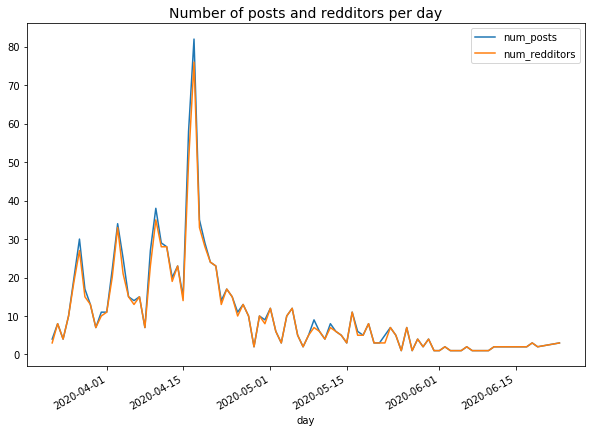

In [6]:
ax=gdf2.plot(x='day', y=["num_posts","num_redditors"], kind="line",figsize=(10,7)); 
ax.set_title('Number of posts and redditors per day', fontsize=14);

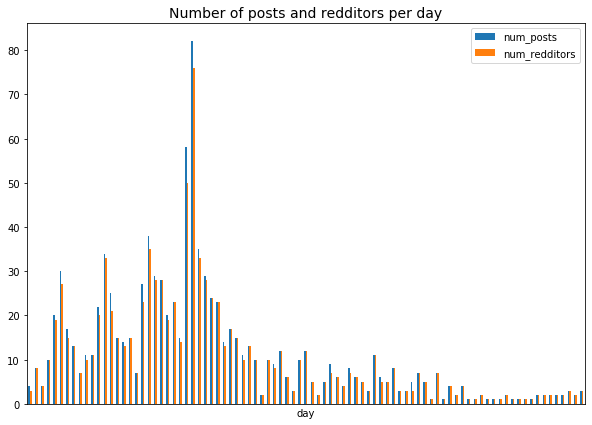

In [7]:
# If the above line-plot does not look nice, please try the bar-plot as follows:

ax=gdf2.plot(x='day', y=["num_posts","num_redditors"], kind="bar",figsize=(10,7)); 
ax.set_title('Number of posts and redditors per day', fontsize=14);
plt.xticks([], []);

In [8]:
posts['index'] = range(1, len(posts) + 1)
postsC=posts[['index','title', 'score', 'redditor', 'url', 'num_comments', 'body', 'created','day']]
docs_d={}
for i in range(npo):
    j=posts.iloc[i]['body']
    a=posts.iloc[i]['index']
    d=posts.iloc[i]['created']
    if type(j)!=float:
        j=j.lower()
        j=j.lstrip().replace("\r","").replace("\n.\n.\n"," ").replace("\n."," ").replace("\n"," ")
        docs_d[a]=(d,j)
    else:
        docs_d[a]=(d,"")
print(len(docs_d))
docs=list([t[1] for t in docs_d.values()])
print(len(docs))
for k,v in docs_d.items():
    print(k,v[0],'\n',v[1])
    print('')

1000
1000
1 2020-03-22 01:34:06 
 

2 2020-03-22 13:18:09 
 i looked at all previously published trailers and found that there is a room in the lab that we have not seen so far. i took some screenshots of it and gathered them here. anyone interested in looking at them should be warned about possible spoilers.  &#x200b;  [in the room there is a machine with an upper and lower part.  on the lower part of the machine there are 6 different objects placed on the 6 corners of the hexagon. the 6 mechanical \\"arms\\" on the upper part are directed at the objects on the lower part of the machine.](https://preview.redd.it/lv2z4rrkh5o41.jpg?width=1159&format=pjpg&auto=webp&s=ff9edd9a1b95248b5d787bc961c82f915b91e5bd)  [there is a room with multiple terminals with an entrance to the machine. forest, katie, stewart and some one else is in this room. maybe lily?](https://preview.redd.it/4fjajm2uj5o41.jpg?width=1193&format=pjpg&auto=webp&s=4d176873eca4d102a9b7890dfc82de8401dbeebb)  [there is a screen

 

387 2020-04-12 13:58:56 
 i don't exactly know how the machine works, but based on katie's decision, it has the full knowledge of the universe to be able to create a perfect prediction of the future and an image of the past. but, if it has the power to determine how 7 billion people would think and decide, wouldn't this kind of machine be able to create a mind of it's own? i'm not saying that it will and maybe even this discussion is beyond us tv watchers and is for the scientist. but it just makes me wonder if it can create 7 billion minds to the exact, could it also be able to create a mind of it's own or not.

388 2020-04-12 15:08:31 
 

389 2020-04-12 18:51:20 
 i'm more interested in exploring the character and storytelling themes of the show rather than the science and concept theories i'm seeing here.   so garland has talked a lot about how silicon valley figures perceive themselves as gods, how they basically live in a bubble. he’s directly critiqued their single mindedness 

 the key to understanding what happened is lyndon's decision to use everett's many worlds interpretation.   forest was furious with lyndon because when he used everett's mw interpretation to filter out all but one of the pasts he was trying to listen to, it became all but certain the jesus they were hearing was not the jesus from their past. (there are infinite jesuses according to the mwi, so the odds of it being the jesus from their past is something like 1/infinity. that's small.) let's assume for the sake of argument and simplicity that the only difference was a single hair on jesus's head.    eventually, we see forest's concerns were legitimate: using the mwi to clarify the images/sounds leads to a divergence when lily doesn't shoot forest. no matter how accurately deus has predicted their future *so far*, it is still imperfect, because it is extrapolating a specific past's future -- the future that resulted from a past where nothing is different except a single hair on jesus's he

In [9]:
num_unique_words=[]
for k,v in docs_d.items():
    words = word_tokenize(v[1])
    nuw=len(words)
    uw=len(set(words))
    num_unique_words.append(uw)
#     print("Post on %s contains %i nonunique and %i unique words"%(k,nuw,uw))
posts['num_unique_words']=num_unique_words
gdf3=posts.groupby("day").sum()[["num_unique_words"]]
gdf3 = gdf3.reset_index()
gdf4 = pd.merge(gdf2, gdf3, on='day')
gdf4=gdf4[['day','num_posts','num_comments','num_unique_words']]
gdf4

,day,num_posts,num_comments,num_unique_words
0,2020-03-22,4,93,513
1,2020-03-23,8,98,343
2,2020-03-24,4,103,272
3,2020-03-25,10,120,702
4,2020-03-26,20,1097,880
...,...,...,...,...
84,2020-06-16,2,24,83
85,2020-06-17,2,24,104
86,2020-06-18,3,35,444
87,2020-06-19,2,15,380


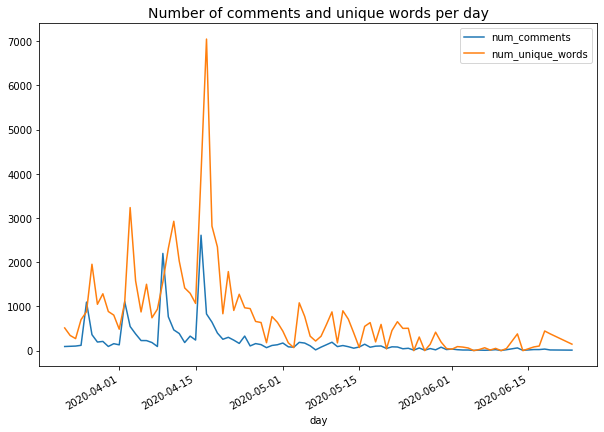

In [10]:
ax=gdf4.plot(x='day', y=["num_comments",'num_unique_words'], kind="line",figsize=(10,7)); 
ax.set_title('Number of comments and unique words per day', fontsize=14);

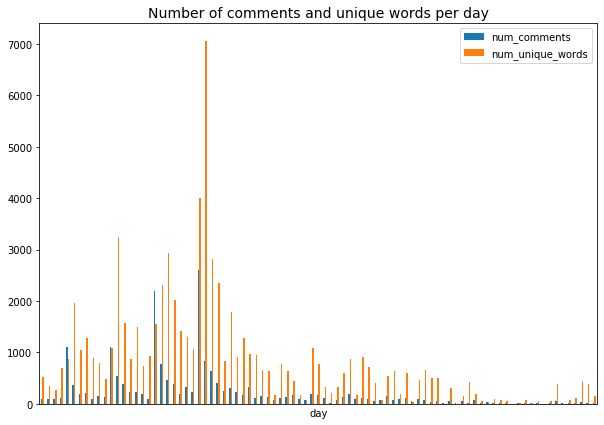

In [11]:
# If the above line-plot does not look nice, please try the bar-plot as follows:

ax=gdf4.plot(x='day', y=["num_comments",'num_unique_words'], kind="bar",figsize=(10,7)); 
ax.set_title('Number of comments and unique words per day', fontsize=14);
plt.xticks([], []);

In [12]:
p = inflect.engine()
d_tags = {}

text=" ".join(docs)
docs_d={subreddit:text}
for key, value in docs_d.items():
    arr = []
    doc = nlp(value.replace('\n',''))
    #Keep these types of nlp entities
    keep_l = ['PERSON'] #,'NORP','PRODUCT','ORG']
    #Typo/model error + german corrections
    drop_t = []
    
    #Things inflect library handles poorly or to exclude from touching
    ex_ls = []
    
    for X in doc.ents:
        s1 = X.text
        if (X.label_ in keep_l) and (s1.lower() not in drop_t) and (s1):
            arr.append((s1, X.label_))
    d_tags[key] = arr
# pprint(d_tags)
names=[]
for k,v in d_tags.items():
    for vv in v:
        if vv[0] not in names:
            p=vv[0].replace("'","")
            p=p.title()
            names.append(p)
names=sorted(set(names))
print(len(names))
names

369


['/Watch?V=5Xclvj2Jgta',
 '101',
 'A Ted Chiang',
 'A U. Deus',
 'Aaron Paul',
 'Abraham',
 'Abraham Lincoln',
 'Abraham Lincoln’S',
 'Achilles',
 'Adam',
 'Agamemnon',
 'Alan Turing',
 'Alex',
 'Alex Garland',
 'Alex Garland Makin',
 'Alex Garlands',
 'Alex Garland’S',
 'Alicia Vikander',
 'Aline',
 'Alison Pills',
 'Allison',
 'Alphago',
 'Alphago Wiki',
 'Alphazero',
 'Amaya',
 'Amaya Lanyard',
 'Amaya Mizuno-André',
 'Amya',
 'Angel Samuel',
 'Anton',
 'Antony',
 'Apprntly Teh Dum',
 'Arc',
 'Arthur',
 'Arthur C. Clarke',
 'Arthur Miller',
 'Asimov',
 'Aubade',
 'Ava',
 'Bach',
 'Ben Kingsley',
 'Ben Salisbury',
 'Bf',
 'Bf Jamie = Lily',
 'Blake Crouch',
 'Blake Crouch](Https://Www.Goodreads.Com',
 'Bostrom',
 'Break Lily’S',
 'Breaking Anton’S',
 'Brian Greene',
 'Buddha',
 'Buddhism',
 'Byronic',
 'Byung-Chul Han',
 'Cailee',
 'Cailee Spaeny',
 'Caleb',
 'Carlo Rovelli',
 'Carpenter',
 'Carroll',
 'Casablana',
 'Chekhov',
 'Chiang',
 'Christ',
 'Chul Han',
 'Cleopatra',
 'Cleopa

In [13]:
rem=[]
for p in names:
    if "_" in p:
        rem.append(p)
    if "-" in p:
        rem.append(p)
    if "Watch" in p:
        rem.append(p)
    if "--" in p:
        rem.append(p)
    if "Https" in p:
        rem.append(p)
    if "’" in p:
        rem.append(p)
    if ":" in p:
        rem.append(p)
    if len(p)<3:
        rem.append(p)
#     if p not in text:
#         rem.append(p)
names=[p for p in names if p not in rem]
print(len(names))
pp=[q for q in itertools.product(names,names) if q[0]!=q[1]]
for q in pp:
    if q[0] in q[1]:
        rem.append(q[0])
    if q[1] in q[0]:
        rem.append(q[1])
    w=q[0]+" "+q[1]
    if w in text:
        names.append(w)
        rem.append(q[0])
        rem.append(q[1])
names=[p for p in names if p not in rem]
names=sorted(set(names))
print(len(names))
names

333
270


['101',
 'A Ted Chiang',
 'A U. Deus',
 'Aaron Paul',
 'Abraham Lincoln',
 'Achilles',
 'Adam',
 'Agamemnon',
 'Alan Turing',
 'Alex Garland Makin',
 'Alex Garlands',
 'Alicia Vikander',
 'Aline',
 'Alison Pills',
 'Allison',
 'Alphago Wiki',
 'Alphazero',
 'Amaya Lanyard',
 'Amya',
 'Angel Samuel',
 'Apprntly Teh Dum',
 'Arc',
 'Arthur C. Clarke',
 'Arthur Miller',
 'Aubade',
 'Ava',
 'Bach',
 'Ben Kingsley',
 'Ben Salisbury',
 'Bf Jamie = Lily',
 'Blake Crouch',
 'Brian Greene',
 'Buddha',
 'Buddhism',
 'Byronic',
 'Cailee Spaeny',
 'Caleb',
 'Carlo Rovelli',
 'Carpenter',
 'Casablana',
 'Chekhov',
 'Chul Han',
 'Cleopatra =',
 'Clicheed',
 'Cobb',
 'Coltrane',
 'Confucius',
 'Crosby',
 'Cubit',
 'Cypher',
 'Dan Akroyd',
 'Daniel Dennett',
 'Daniel Wegner',
 'David Alberts',
 'David Deutsch',
 'David Foster Wallace',
 'David Lee',
 'David Wallace',
 'Debrogille',
 'Deteminism',
 'Deus Vult',
 'Devouts',
 'Dolores',
 'Douglas Hofstadter',
 'Dwar Ev',
 'Dwar Reyn',
 'Eddy Nahmias',
 'E

In [14]:
# Read carefully the above list of names, and add names in the two lists rem and added

rem=['Jodie Whittakers','Tony Starks','Christopher Ecclestons','Amright','Peter Capaldis',
     'Lesley Sharps','David Tennants','Chris Chibnalls',
     'Lillith',
 'Lily "Neo',
 'Lily Chan',
 'Lily Shooting Forrest',
 'Lilys','Jamie ❤','It‘S Lily'
    
    ]
# rem=[i.lower() for i in rem]
added=['Lily','Jamie']
names=[p for p in names if p not in rem]
names=names+added
names=sorted(set(names))
print(len(names))
names

265


['101',
 'A Ted Chiang',
 'A U. Deus',
 'Aaron Paul',
 'Abraham Lincoln',
 'Achilles',
 'Adam',
 'Agamemnon',
 'Alan Turing',
 'Alex Garland Makin',
 'Alex Garlands',
 'Alicia Vikander',
 'Aline',
 'Alison Pills',
 'Allison',
 'Alphago Wiki',
 'Alphazero',
 'Amaya Lanyard',
 'Amya',
 'Angel Samuel',
 'Apprntly Teh Dum',
 'Arc',
 'Arthur C. Clarke',
 'Arthur Miller',
 'Aubade',
 'Ava',
 'Bach',
 'Ben Kingsley',
 'Ben Salisbury',
 'Bf Jamie = Lily',
 'Blake Crouch',
 'Brian Greene',
 'Buddha',
 'Buddhism',
 'Byronic',
 'Cailee Spaeny',
 'Caleb',
 'Carlo Rovelli',
 'Carpenter',
 'Casablana',
 'Chekhov',
 'Chul Han',
 'Cleopatra =',
 'Clicheed',
 'Cobb',
 'Coltrane',
 'Confucius',
 'Crosby',
 'Cubit',
 'Cypher',
 'Dan Akroyd',
 'Daniel Dennett',
 'Daniel Wegner',
 'David Alberts',
 'David Deutsch',
 'David Foster Wallace',
 'David Lee',
 'David Wallace',
 'Debrogille',
 'Deteminism',
 'Deus Vult',
 'Devouts',
 'Dolores',
 'Douglas Hofstadter',
 'Dwar Ev',
 'Dwar Reyn',
 'Eddy Nahmias',
 'E

In [15]:
nfreq=[]
for i in names: 
    nfreq.append(text.count(i.lower()))
pnf_df = pd.DataFrame(
    {'Names': names, 
     'Frequency of Occurrences': nfreq
    })
pnf_df=pnf_df[['Names','Frequency of Occurrences']]
pnf_df=pnf_df.sort_values(by ='Frequency of Occurrences',ascending=False)
# trf_df=trf_df[trf_df["Frequency of Occurrences"]>10]
print(len(pnf_df))
pnf_df #.tail(10) #[:50]

265


,Names,Frequency of Occurrences
154,Lily,683
172,Maya,120
105,Jamie,80
245,Tera,74
140,Kenton,68
...,...,...
95,Isaac Asimovs,0
171,Max Tegmarks,0
72,Fcked,0
92,Hugh Everetts,0


In [16]:
x = pnf_df.set_index('Names').T.to_dict()
x=sorted([(k,v['Frequency of Occurrences']) for k,v in x.items()], key=lambda x: x[1],reverse=True)
for i,j in x:
    if j==0:
        print(i)

King O Da Castle
David Alberts
Alison Pills
Isaac Asimovs
Max Tegmarks
Fcked
Hugh Everetts
Greg Egans


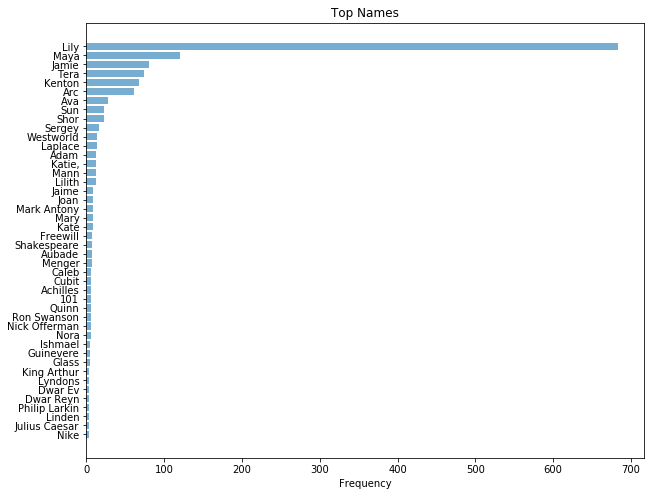

In [17]:
x = pnf_df.set_index('Names').T.to_dict() 
x=sorted([(k,v['Frequency of Occurrences']) for k,v in x.items()], key=lambda x: x[1],reverse=True)
keys = [i for (i,j) in x if j>3] 
y_pos = np.arange(len(keys))
performance = [j for (i,j) in x if j>3] 
plt.figure(figsize=(10,8))
ax = plt.axes()
plt.barh(y_pos, performance, align='center', alpha=0.6) 
ax.invert_yaxis()
plt.yticks(y_pos, keys)
plt.xlabel('Frequency')
plt.title('Top Names')
plt.show()

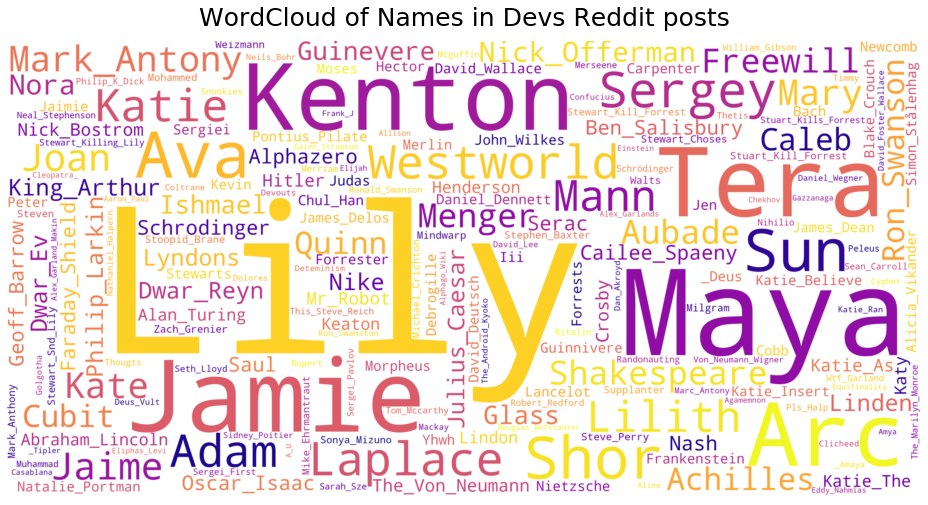

In [18]:
t=[]
for (i,j) in x:
    for k in range(j):
#         print i.replace(" ","_").replace("-","_")
        t.append(i.replace(" ","_").replace("-","_"))
ttd=' '.join(t)
wordcloud = WordCloud(collocations=False,background_color="white",colormap="plasma",width=4000,height=2000).generate(ttd)
fig = plt.figure(figsize=(13,13))
default_colors = wordcloud.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
ss="WordCloud of Names in %s" %titlename
plt.suptitle(ss,fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 1.4]) 
plt.show()

In [19]:
# WITHOUT ALIASES:
alias_dict={}
for n in names:
    alias_dict[n]=n

# # WITH ALIASES:
# alias_dict={}
# for n in names:
#     if n=="try":
#         alias_dict[n]="tri"
#     elif n=="tries":
#         alias_dict[n]="tri"
#     elif n=="tried":
#         alias_dict[n]="tri"
#     elif n=="send":
#         alias_dict[n]="send"
#     elif n==" sent ":
#         alias_dict[n]="send"
#     elif n=="feel":
#         alias_dict[n]="feel"
#     elif n=="felt":
#         alias_dict[n]="feel"
#     else:
#         alias_dict[n]=n

In [20]:
blob = TextBlob(text)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in [w.lower() for w in list(set(alias_dict.values()))]:
        if term in v: 
            wl.append(term.title())
    if len(wl)>1:
        sendic[i]=wl 
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if alias_dict[jj[0]]!=alias_dict[jj[1]]:
            medges.append((alias_dict[jj[0]],alias_dict[jj[1]],"Sentence_"+str(k),ss/float(s)))
# print("%s contains %i sentential co-occurrences among %i aliased proper nouns"%(titlename,len(medges),len(set(alias_dict.values()))))
medges

[('Joan', 'Arc', 'Sentence_80', 0.0),
 ('Lily', 'Shor', 'Sentence_81', 0.13333333333333333),
 ('Coltrane', 'Bach', 'Sentence_152', 0.0),
 ('Lex Friedman', 'Nick Bostrom', 'Sentence_194', 0.15),
 ('Jamie', 'Kenton', 'Sentence_205', -0.4),
 ('Lily', 'Kenton', 'Sentence_253', 0.0),
 ('Jaimie', 'Arc', 'Sentence_265', 0.2),
 ('Arc', 'Kenton', 'Sentence_265', 0.2),
 ('Jaimie', 'Kenton', 'Sentence_265', 0.2),
 ('Cypher', 'Keaton', 'Sentence_273', 0.5),
 ('Lily', 'Jamie', 'Sentence_285', -0.1),
 ('Lily', 'Jamie', 'Sentence_294', -0.25),
 ('Forrester', 'Carpenter', 'Sentence_320', 0.0),
 ('Sergey', 'Kenton', 'Sentence_413', 0.18666666666666668),
 ('Sergey', 'Kenton', 'Sentence_431', -0.05510204081632653),
 ('Sergey', 'Maya', 'Sentence_432', 0.0),
 ('Lily', 'Maya', 'Sentence_438', 0.2857142857142857),
 ('Lily', 'Jamie', 'Sentence_481', 0.0),
 ('Arc', 'Frankenstein', 'Sentence_486', 0.1630555555555556),
 ('Lily', 'Ava', 'Sentence_496', 0.0),
 ('Joan', 'Arc', 'Sentence_498', 0.1025),
 ('Lily', 'Ja

In [21]:
medgesd=[]
for e in medges:
    d={}
    d['Sentence']=e[2]
    d['Average sentiment']=e[3]
    medgesd.append((e[0],e[1],d))
    
G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)

if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
giant = max(connected_component_subgraphs(Gw), key=len)
Gwlcc=Gw.subgraph(giant)

This graph is a disconnected graph and it has 24 connected components


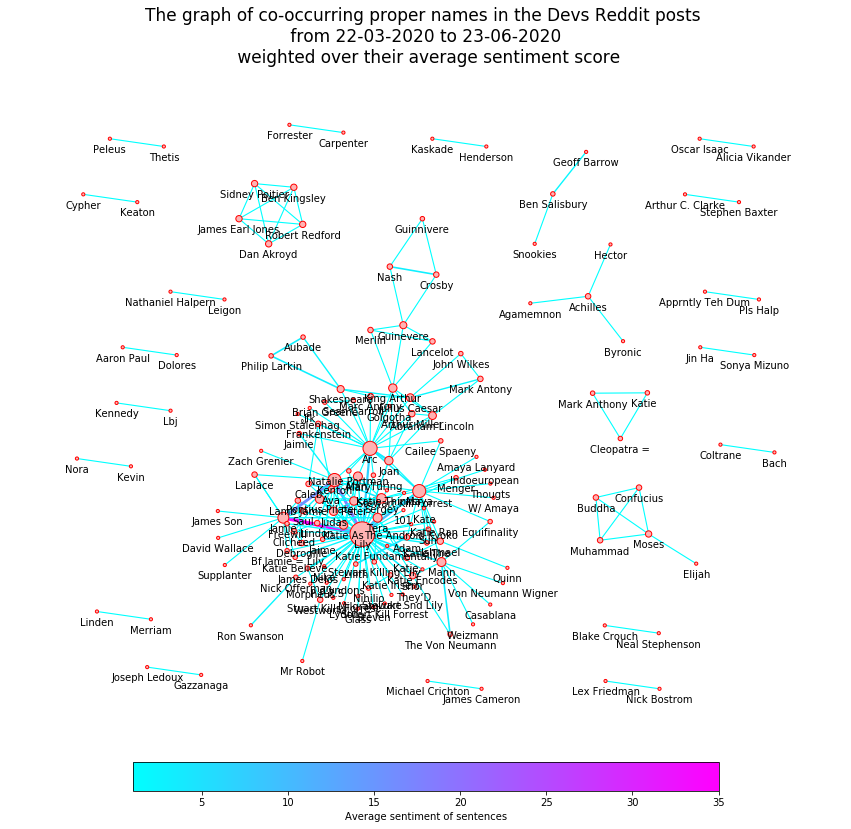

In [22]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
width_list=[1*math.log(2+w) for w in weight_list]
# width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[10*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=width_list,alpha=1)
plt.axis('off');
yoffset = {}
y_off = -15 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
titlename1="%s \n from %s to %s" %(titlename,mind[:10],maxd[:10])
sst="The graph of co-occurring proper names in the %s \n weighted over their average sentiment score" %titlename1
plt.title(sst,fontsize=17);
plt.margins(x=0.1, y=0.1) 

In [23]:
nodes=len(Gw.nodes())
edges=len(Gw.edges())
print(nodes,edges) #,nodes*(nodes-1)/2)

159 232


In [24]:
# edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
# # edge_width=[math.log(1+w) for w in edge_width]
# cmap=plt.cm.cool
# weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
# edge_color=weight_list
# vmin = min(edge_color) 
# vmax = max(edge_color) 
# # width_list=[2*math.log(2+w) for w in weight_list]
# width_list=[0.1*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
# nsi=[10*Gw.degree(n) for n in Gw.nodes()]

# figsize=(15,15)

# pos=graphviz_layout(Gw) 
# # pos=nx.spring_layout(Gw)

# node_color="#ffb3b3"
# node_border_color="r"
# plt.figure(figsize=figsize);
# nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
# nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.6)
# plt.axis('off');
# yoffset = {}
# y_off = -15 # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(Gw, yoffset,font_size=10);
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
# cbar.set_label('Average sentiment of sentences')
# titlename1="%s \n from %s to %s" %(titlename,mind[:10],maxd[:10])
# sst="The graph of co-occurring proper names in the %s \n weighted over their average sentiment score" %titlename1
# plt.title(sst,fontsize=17);
# plt.margins(x=0.1, y=0.1) 